In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)


('2017-08-23',)


2016-08-22 00:00:00


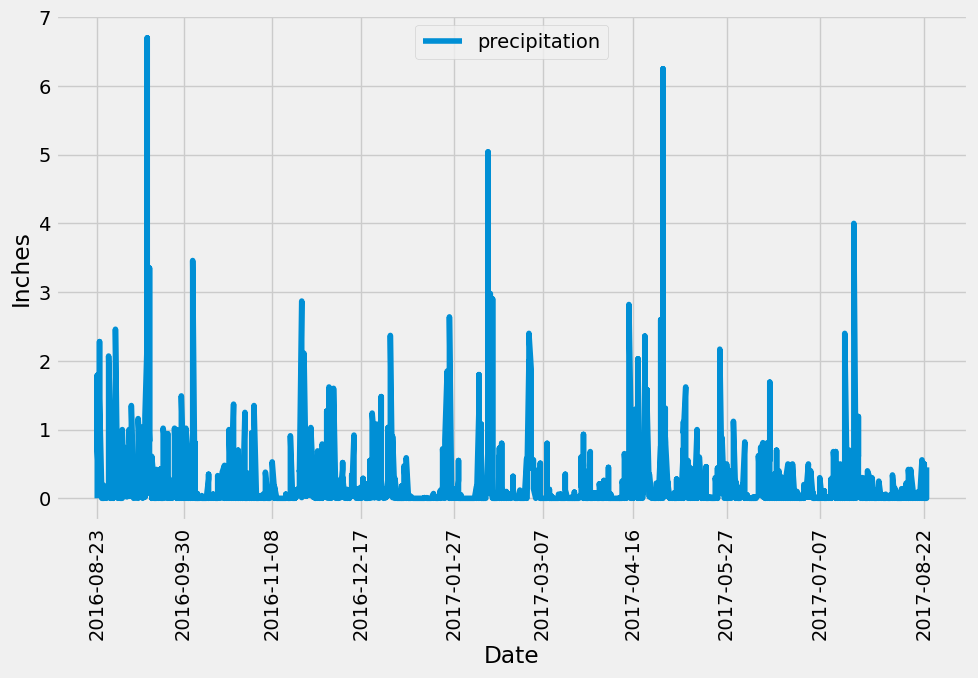

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 


# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date[0], '%Y-%m-%d') - dt.timedelta(days=366)
print(one_year_ago)

# Perform a query to retrieve the data and precipitation scores
Data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago ).\
    order_by(measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation = pd.DataFrame(Data, columns=['Date','Inches'])
precipitation


precipitation1 = precipitation.dropna(how='any')

# Sort the dataframe by date

precipitation_sorted = precipitation1.sort_values(by='Date')
precipitation_sorted


# Use Pandas Plotting with Matplotlib to plot the data

plt.figure(figsize=(10,7))
plt.plot(precipitation_sorted['Date'], precipitation_sorted['Inches'], label='precipitation') 
plt.legend(loc='upper center')
plt.xlabel('Date')
plt.ylabel('Inches')
num_xlabels = 9
step = len(precipitation_sorted) // num_xlabels
index_label = list(range(0, len(precipitation_sorted), step))
Sample_date = precipitation_sorted['Date'].iloc[index_label]
plt.xticks(Sample_date, rotation='vertical')

plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data

agg_functions = {
    'count': 'count',
    'mean': 'mean',
    'std': 'std',
    'min': 'min',
    'percentile_25': lambda x: x.quantile(0.25),
    'percentile_50': lambda x: x.quantile(0.50),
    'percentile_75': lambda x: x.quantile(0.75),
    'max': 'max'
}

Summary_stat = pd.DataFrame(precipitation_sorted['Inches'].agg(agg_functions))
Summary_stat


,Inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
percentile_25,0.000000
percentile_50,0.020000
percentile_75,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
Stations = session.query(measurement).group_by(measurement.station).count()
Stations



9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


active_stations = session.query(measurement.station, func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

stats_station = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
            filter(measurement.station == active_stations[0].station).all()
print(stats_station)
    
#tobs

[(54.0, 85.0, 71.66378066378067)]


     Temperature
0           77.0
1           77.0
2           80.0
3           80.0
4           75.0
..           ...
347         77.0
348         77.0
349         76.0
350         76.0
351         79.0

[352 rows x 1 columns]


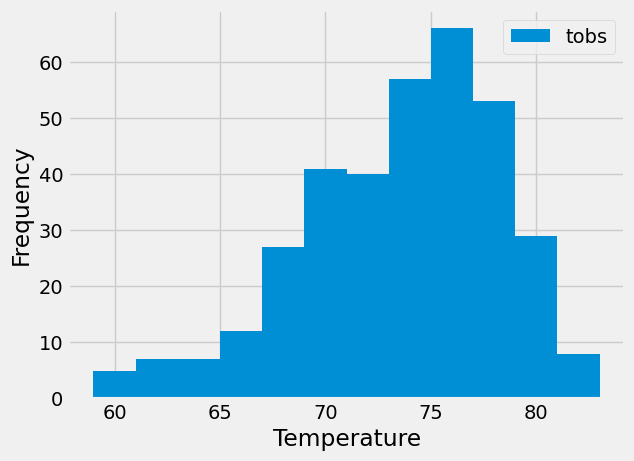

In [29]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Design a query to get the previous 12 months of temperature observation (TOBS) data. To do so, complete the following steps:
# Filter by the station that has the greatest number of observations.
# Query the previous 12 months of TOBS data for that station


data2 = session.query(measurement.tobs).\
    filter(measurement.station == active_stations[0].station).\
    filter(measurement.date >= one_year_ago )

data2


#Save the query results as a Pandas DataFrame. Explicitly set the column names

temperature = pd.DataFrame(data2, columns=['Temperature'])
print(temperature)


# Plot the results as a histogram with bins=12, as the following image shows:


plt.hist(temperature, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


# Close Session

In [34]:
# Close Session
session.close()